# Make analysis of rasters/gpfa and spectrograms/pca

For every run in the session:
 - Load the h5 file generated with the 
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts
- sort_raster_bout:
    - syncrhonization of nidaq/ap time events
    - spike sorting
    - labeling of sorted units for their corresponding nucleus
    - inspection of rasters
    
- load_raster_bout_gpfa
    - for all curated bouts:
        - get the rasters
        - get the spectrograms
    - get the gpfa projections
    - get the pca projections
    - save everything into a h5f file
    
This notebook should not depend on anything other than the h5 file

In [4]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json
import h5py

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal, stats
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

2022-06-13 18:21:32,178 root         INFO     Running on pakhi


In [5]:
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import fileutil as fu
from ceciestunepipe.util import h5util as h5u
#from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp

from ceciestunepipe.pipeline import searchbout as sb

logger.info('all modules loaded')

2022-06-13 18:21:34,411 root         INFO     all modules loaded


In [6]:
pd.__version__

'1.4.2'

### Session parameters

In [7]:
reload(et)

bird = 's_b1555_22'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [8]:
reload(et)

sess_par = {'bird': bird,
           'sess': '2022-04-29',
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': None, # if there was a stimulus epoch, where the stimuli were coming from
           'mic_chan': 0, # where the microphone is in the wav_mic.npy array
           'pre_chan': 0} # where the pressure is in the wav_adc.npy array




In [9]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2022-06-13 18:21:43,380 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx', 'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-04-29', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-04-29', 'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/rig.json', 'kwd': '/scratch/

['0644_g0', '1055_g0', '1530_g0', '2234_stim_g0']

In [10]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

derived_folder = exp_struct['folders']['derived']

In [11]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/0644_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/0644_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/0644_g0',
  'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-04-29/0644_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/0644_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/0644_g0',
  'tmp': '/scratch/earneodo/tmp/0644_g0',
  'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-04-29/0644_g0',
  'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/0644_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/0644_g0/sort_0'},
 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/0644_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-0

In [12]:
bout_h5_path = os.path.join(exp_struct['folders']['processed'], 'bout_df_gpfa.h5')
bout_h5_path

'/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/0644_g0/bout_df_gpfa.h5'

### load epoch h5 file

load the elements of an bout_df_gpfa.h5 file
in the h5 file

In [14]:
def bouts_from_h5(bout_h5_path, root_grp_name: str='bout_gpfa', exclude_dset=['spk_arr']):
    # open a h5 file.
    # read the group for the dataframe
    # append the bout metada dict keys to the group
    # for each group (bout)
        # create a dataframe with the salars from the attributes, and 
        # pointers to the datasets for the tables
    
    all_bout_df = pd.DataFrame()
    with h5py.File(bout_h5_path,'r') as f:
        df_grp = f[root_grp_name]
        grp_attr_dict = h5u.obj_attrs_2_dict_translator(df_grp)
        # each key in the df_grp is a group, and each group is a bout
        #logger.info(bout_idx_list)
        for bout_idx in df_grp.keys():
            bout_grp = df_grp[bout_idx]
            bout_attr_dict = h5u.obj_attrs_2_dict_translator(bout_grp)
            bout_data_dict = ({k: bout_grp[k][:] for k in bout_grp.keys() if not (k in exclude_dset)})
            bout_data_dict.update(bout_attr_dict)

            bout_df = pd.DataFrame(pd.Series(bout_data_dict)).T
            bout_df['bout_idx'] = bout_idx
            all_bout_df = pd.concat([all_bout_df, bout_df])
    
    return all_bout_df, grp_attr_dict

bout_h5_path = os.path.join(exp_struct['folders']['processed'], 'bout_df_gpfa.h5')
bout_df, bout_dict = bouts_from_h5(bout_h5_path, exclude_dset=['spk_arr'])

In [15]:
bout_df.keys()

Index(['f_xx', 'mic_arr', 'pre_arr', 'pre_filt', 's_xx', 'spk_gpf', 'sxx_pc',
       'syl_in', 't_xx', 'bout_check', 'confusing', 'end_ms', 'end_sample',
       'end_sample_ap_0', 'file', 'len_ms', 'len_sample_ap_0', 'start_ms',
       'start_ms_ap_0', 'start_sample', 'start_sample_ap_0',
       'start_sample_naive', 'bout_idx'],
      dtype='object')

In [16]:
bout_df.reset_index(inplace=True)

In [17]:
bout_dict

{'s_f': 40000,
 's_f_ap_0': 30000.02776121381,
 's_f_nidq': 39999.39190353144,
 't_post': 2,
 't_pre': -2}

In [18]:
bout_df.iloc[0]['pre_filt'].shape

(2648400,)

In [19]:
bout_df.iloc[0]['mic_arr'].shape

(2648400,)

In [20]:
fu

<module 'ceciestunepipe.util.fileutil' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/fileutil.py'>

In [21]:
def bout_to_henri(bout_s: pd.Series, s_f):
    pre_filt = bout_s['pre_filt']
    mic = bout_s['mic_arr']
    
    return 
    
def fur_henri(bout_df: pd.DataFrame, bout_dict: dict, folder:str):
    # for each bout, make files:
    # bout-{}_pre.csv
    # bout-{}_mic.csv
    
    s_f = bout_dict['s_f_nidq']
        
    for idx, row in bout_df.iterrows():
        
        pre_path, mic_path = [os.path.join(folder, 'bout-{:03}_{}.csv'.format(idx, z)) for z in ['pre', 'mic']]
        
        pre_arr, mic_arr = [row[z].flatten()[80000:-80000] for z in ['pre_filt', 'mic_arr']]
        
        t = np.arange(pre_arr.size)/s_f
        
        for arr, arr_path in zip((pre_arr, mic_arr), (pre_path, mic_path)):
            t_arr = np.vstack([t, arr])
            #print(t_arr.shape)
            np.savetxt(arr_path, t_arr.T)

henri_path = os.path.join(exp_struct['folders']['processed'], 'hdi')
fu.makedirs(henri_path)
fur_henri(bout_df, bout_dict, henri_path)

In [22]:
henri_path

'/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/0644_g0/hdi'

In [168]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/0644_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/0644_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/0644_g0',
 'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-04-29/0644_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/0644_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/0644_g0',
 'tmp': '/scratch/earneodo/tmp/0644_g0',
 'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-04-29/0644_g0',
 'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/0644_g0/sort_0',
 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/0644_g0/sort_0'}

In [12]:
bout_df.reset_index(inplace=True)

In [13]:
# f = h5py.File(bout_h5_path,'r')
# df_grp = f['bout_gpfa']
# bout_grp = df_grp['0']
# bout_attr_dict = h5u.obj_attrs_2_dict_translator(bout_grp)
# bout_data_dict = ({k: bout_grp[k][:] for k in bout_grp.keys()})
# bout_data_dict.update(bout_attr_dict)
# bout_series = pd.Series(bout_data_dict)
# bout_df = pd.DataFrame(bout_series, )

### Visualize a bout together with the neural traces

In [14]:
plt.rcParams['lines.linewidth'] = 0.1

In [15]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

##### sanity check, plot one of the bout-rasters

NameError: name 'spk_arr' is not defined

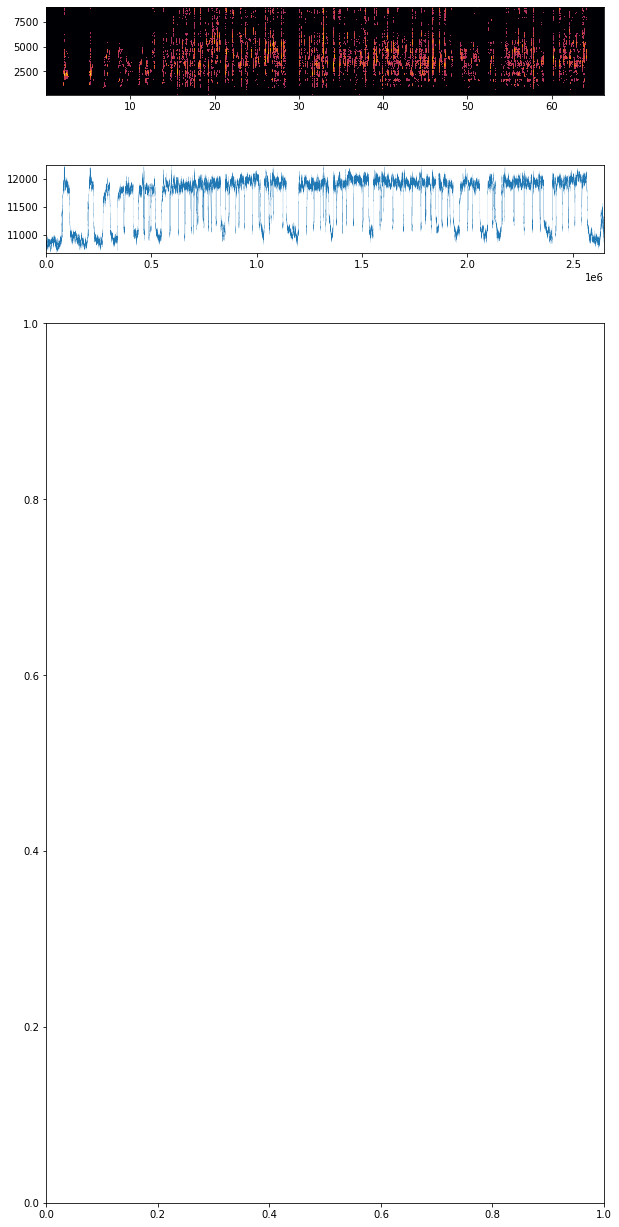

In [22]:
def plot_bout(bout_series, bout_dict):
    # get the raster, the spectrogram and the pressure
    
    t_pre = bout_dict['t_pre']
    s_f_ap = bout_dict['s_f_ap_0']
    s_f = bout_dict['s_f']
    
    mic_arr = bout_series['mic_arr']
    pre_arr = bout_series['pre_arr']
    #spk_arr = bout_series['spk_arr']
    # plot
    
    fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

    f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f)

    #ax[0].plot(mic_arr.flatten())
    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[1].plot(pre_arr.flatten());
    pu.plot_as_raster(spk_arr, t_0=int(-t_pre*s_f_ap), ax=ax[2])
    
plot_bout(bout_df.iloc[0], bout_dict)

array([<AxesSubplot:>, <AxesSubplot:ylabel='sound amplitude (arb)'>,
       <AxesSubplot:title={'center':'spectrogram PC'}>,
       <AxesSubplot:title={'center':'RA GPFA'}>,
       <AxesSubplot:title={'center':'pressure'}>], dtype=object)

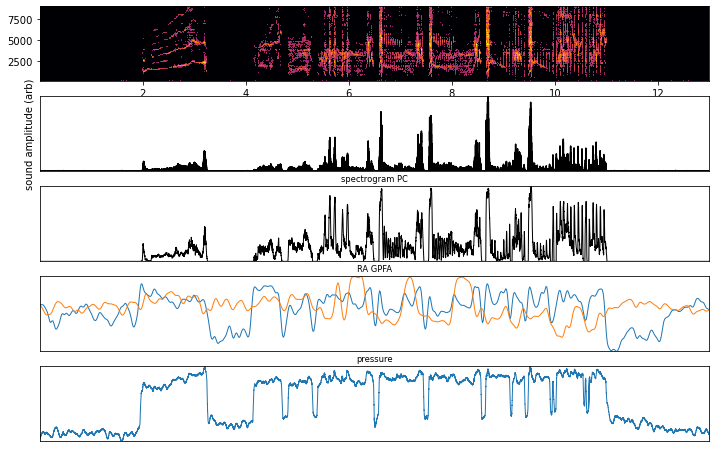

In [26]:
### se them together all for a bout now
def plot_bout_projections(bout_series):
    sxx_pc = bout_series['sxx_pc']
    gpf = bout_series['spk_gpf']
    pre_arr = bout_series['pre_filt']
    mic_arr = bout_series['mic_arr']
    
    f, t, sxx = tuple([bout_series['f_xx'], bout_series['t_xx'], bout_series['s_xx']])
    
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 8));

    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    
    ax[1].plot((np.abs(mic_arr)), 'k');
    ax[1].set_ylabel('sound amplitude (arb)')

    ax[2].set_title('spectrogram PC')
    ax[2].plot(sxx_pc[:, 0], 'k', lw=1);

    ax[3].set_title('RA GPFA');
    ax[3].plot(gpf[:2].T, lw=1);

    ax[4].set_title('pressure');
    ax[4].plot(pre_arr, lw=1);
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    
    return ax


plot_bout_projections(bout_df.iloc[40])

#### a multivariate regression

In [17]:
from sklearn.model_selection import train_test_split

#### do crosscorrelation, mutual information analyses

In [18]:
for i in range(3):
    bout_df['spk_gpf_'+ str(i)] = bout_df['spk_gpf'].apply(lambda x: x[i])
    bout_df['spk_gpf_'+ str(2*i+1)] = bout_df['spk_gpf'].apply(lambda x: x[2*i+1])
    bout_df['sxx_pc_'+ str(i)] = bout_df['sxx_pc'].apply(lambda x: x[:, i])

In [19]:
from sklearn.feature_selection import mutual_info_regression
from scipy.signal import correlate2d
from scipy.stats import pearsonr

In [20]:
### make a many_column, continuous dataframe,with the streams of each bout all concatenated

def bout_series_df(bout_s: pd.Series, tag_pair: list=['spk_gpf_0', 'sxx_pc_0']) -> pd.DataFrame:
    # t has to be in last axis
    tag_tuple = tuple(tag_pair)
    
    # subsample everything to the series with the least temporal resolution (gp, 15ms bins)
    n_samp_arr = np.array([bout_s[x].shape[-1] for x in tag_pair])
    #logger.info(n_samp_arr)
    # sort by number of samples (0 is smaller, 1 is larger)
    size_order = np.argsort(n_samp_arr)
    short_tag, long_tag = np.array(tag_pair)[size_order]
    
    # leav the smaller untouched (the 0), subsample the larger (1)
    sizes_ranked = np.sort(n_samp_arr)
    size_ratio = sizes_ranked[1]//sizes_ranked[0]
    
    long_s = pu.coarse(bout_s[long_tag], size_ratio)[:sizes_ranked[0]]
    short_s = bout_s[short_tag]
    
    bout_df = pd.DataFrame({long_tag: long_s, short_tag: short_s})
    #bout_df['bout_idx'] = bout_s['bout_idx']
    return bout_df
    

def bout_df_to_cols(df: pd.DataFrame, tag_pair: list=['spk_gpf_0', 'sxx_pc_0']) -> pd.DataFrame:
    # go over the bout_df and get the two columns in a continous, synced dataframe
    return pd.concat([bout_series_df(x, tag_pair=tag_pair) for i, x in bout_df.iterrows()])

#bout_series_df(bout_df.iloc[0])
#pd.concat([bout_series_df(x) for i, x in bout_df.iterrows()])

bout_df_to_cols(bout_df)

,sxx_pc_0,spk_gpf_0
0,-10.200048,-0.075430
1,-10.200048,-0.060188
2,-10.200048,0.002835
3,-10.200048,0.092895
4,-10.200048,0.167968
...,...,...
3013,-10.200048,-0.126583
3014,-10.200048,-0.240717
3015,-10.200048,-0.304772
3016,-10.200048,-0.315903


In [21]:
pairs_to_df = [['spk_gpf_0', 'sxx_pc_0'], 
               ['spk_gpf_1', 'sxx_pc_1'],
               ['spk_gpf_2', 'sxx_pc_2'],
               ['spk_gpf_3', 'pre_filt']]

cols_df_list = [bout_df_to_cols(bout_df, x) for x in pairs_to_df]

In [22]:
all_col_pd = pd.concat(cols_df_list, axis=1)
all_col_pd

,sxx_pc_0,spk_gpf_0,sxx_pc_1,spk_gpf_1,sxx_pc_2,spk_gpf_2,pre_filt,spk_gpf_3
0,-10.200048,-0.075430,1.442867,0.064940,0.929911,-0.538451,10784.336892,-0.036645
1,-10.200048,-0.060188,1.442867,0.142750,0.929911,-0.533362,10804.323973,-0.005729
2,-10.200048,0.002835,1.442867,0.220287,0.929911,-0.510280,10824.151494,0.055658
3,-10.200048,0.092895,1.442867,0.281735,0.929911,-0.480789,10843.280255,0.135826
4,-10.200048,0.167968,1.442867,0.322489,0.929911,-0.445642,10856.452891,0.211293
...,...,...,...,...,...,...,...,...
3013,-10.200048,-0.126583,1.442867,0.176394,0.929911,0.534675,11037.500606,0.089656
3014,-10.200048,-0.240717,1.442867,0.186865,0.929911,0.562492,11049.295737,0.068895
3015,-10.200048,-0.304772,1.442867,0.184502,0.929911,0.542213,11067.078073,0.078933
3016,-10.200048,-0.315903,1.442867,0.171342,0.929911,0.478519,11069.483811,0.122138


In [23]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

0.3010367187922651

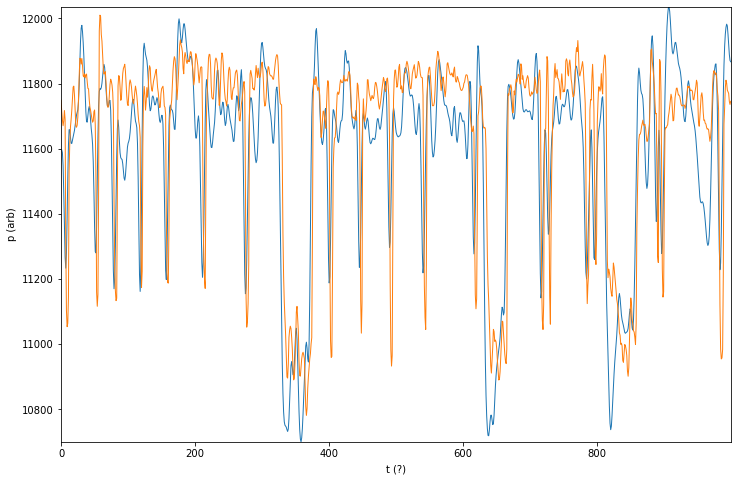

In [69]:
y = all_col_pd['pre_filt'].values
x = all_col_pd[['spk_gpf_0', 'spk_gpf_1', 'spk_gpf_2']].values
x_l = all_col_pd[['spk_gpf_0', 'spk_gpf_1']].values

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

lr = linear_model.Lasso(alpha=0.1)
lr.fit(x_l[:10000], y[:10000].reshape(-1, 1))

y_t = y[10000:]
y_p_l = lr.predict(x_l[10000:])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8));


ax.plot(y_p_l[:1000], lw=1)
ax.plot(y_t[:1000], lw=1)

ax.set_ylabel('p (arb)')
ax.set_xlabel('t (?)')

score = r2_score(y_t, y_p_l)
score

In [67]:
x_l.shape

(130397, 2)

In [66]:
x.shape

(130397, 3)

0.3035022336684461

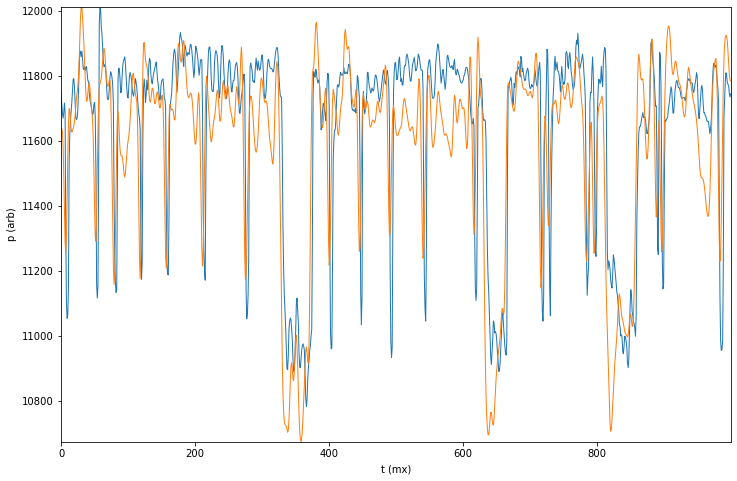

In [74]:
y = all_col_pd['pre_filt'].values
x = all_col_pd[['spk_gpf_0', 'spk_gpf_1', 'spk_gpf_2']].values
x_l = all_col_pd[['spk_gpf_0', 'spk_gpf_1']].values

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

lr = linear_model.Lasso(alpha=0.1)
lr.fit(x[:10000], y[:10000].reshape(-1, 1))

pre_t = y[10000:]
pre_p = lr.predict(x[10000:])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8));

plot_len = 1000
t = np.arange(plot_len)*15

ax.plot(pre_t[:plot_len], lw=1)
ax.plot(pre_p[:plot_len], lw=1)

ax.set_ylabel('p (arb)')
ax.set_xlabel('t (mx)')

score = r2_score(y_t, y_p)
score

0.3035022336684461

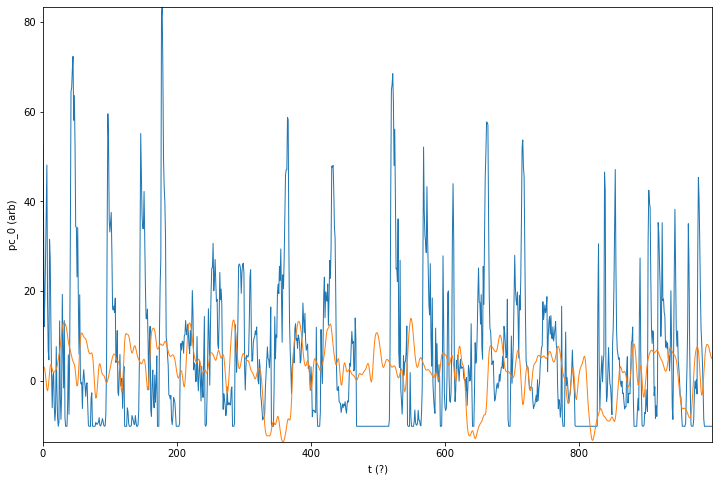

In [75]:
y = all_col_pd['sxx_pc_0'].values
x = all_col_pd[['spk_gpf_0', 'spk_gpf_1', 'spk_gpf_2']].values

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

lr = linear_model.LinearRegression()
lr.fit(x[:10000], y[:10000].reshape(-1, 1))

pc_t = y[10000:]
pc_p = lr.predict(x[10000:])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8));


ax.plot(pc_t[:1000], lw=1)
ax.plot(pc_p[:1000], lw=1)

ax.set_ylabel('pc_0 (arb)')
ax.set_xlabel('t (?)')

score = r2_score(y_t, y_p)
score

0.3035022336684461

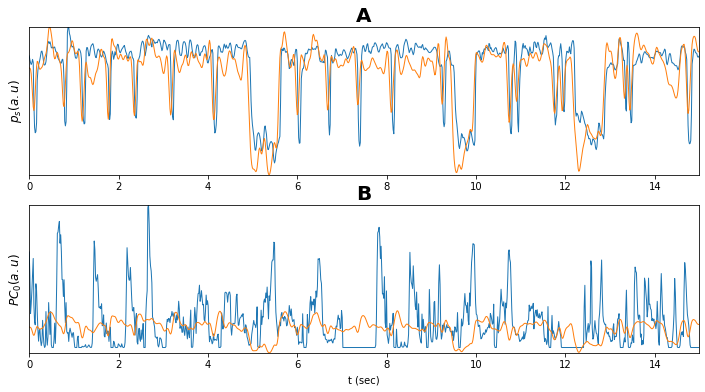

In [112]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6));

plot_len = 1000
t = np.arange(plot_len)*15*0.001

ax[0].plot(t, pre_t[:plot_len], lw=1)
ax[0].plot(t, pre_p[:plot_len], lw=1)
ax[0].set_title('A', fontsize=20, fontweight='bold')
ax[0].set_ylabel(r'$p_{s} (a.u)$', fontsize=12)
ax[0].set_yticks([])

ax[1].plot(t, pc_t[:plot_len], lw=1)
ax[1].plot(t, pc_p[:plot_len], lw=1)
ax[1].set_title('B', fontsize=20, fontweight='bold')

ax[1].set_ylabel(r'$PC_{0} (a.u)$', fontsize=12)
ax[1].set_xlabel('t (sec)')
ax[1].set_yticks([])

score = r2_score(y_t, y_p)
score

In [45]:
mutual_info = lambda x, y: mutual_info_regression(x.reshape(-1, 1), y)

def bout_correlations(bout_s, tag_pair= ['spk_gpf_0', 'sxx_pc_0'], corr_function=mutual_info,
                     shuffle_control=False):
    
    ## t has to be in last axis
    tag_tuple = tuple(tag_pair)
    
    # subsample everything to the series with the least temporal resolution (gp, 15ms bins)
    n_samp_arr = np.array([bout_s[x].shape[-1] for x in tag_pair])
    #logger.info(n_samp_arr)
    # sort by number of samples (0 is smaller, 1 is larger)
    size_order = np.argsort(n_samp_arr)
    short_tag, long_tag = np.array(tag_pair)[size_order]
    
    # leav the smaller untouched (the 0), subsample the larger (1)
    sizes_ranked = np.sort(n_samp_arr)
    size_ratio = sizes_ranked[1]//sizes_ranked[0]
    
    long_s = pu.coarse(bout_s[long_tag], size_ratio)[:sizes_ranked[0]]
    short_s = bout_s[short_tag]
    
    if shuffle_control:
        short_x = np.random.permutation(short_s)
    
    else:
        short_x = short_s
    
    #print(short_x.shape)
    corr_val = corr_function(long_s, short_x)[0]
    return corr_val

bout_correlations(bout_df.iloc[3], corr_function=mutual_info, shuffle_control=False)

0.3445582569410992

In [46]:
corr_pairs = [['sxx_pc_0', 'pre_filt'], ['spk_gpf_0', 'pre_filt'], ['spk_gpf_0', 'sxx_pc_0']]
corr_pairs = [['spk_gpf_0', 'sxx_pc_0'], ['spk_gpf_0', 'pre_filt'],
              ['spk_gpf_1', 'sxx_pc_0'], ['spk_gpf_1', 'pre_filt'],
             ['spk_gpf_0', 'spk_gpf_1']]

corr_pairs = [['spk_gpf_0', 'sxx_pc_0'], ['spk_gpf_0', 'pre_filt']]
corr_dict = {}

for corr_pair in corr_pairs:
    k = corr_pair[0] + '-' + corr_pair[1]
    
    corr_dict[k] =  bout_df.apply(lambda x: bout_correlations(x, corr_pair, 
                                                              corr_function=mutual_info), 
                                  axis=1)
    
    corr_dict[k+'_shuffle'] = bout_df.apply(lambda x: bout_correlations(x, corr_pair, 
                                                              corr_function=mutual_info, 
                                                                       shuffle_control=True), 
                                  axis=1)
    
corr_df = pd.DataFrame.from_dict(corr_dict)

[Text(1, 0, '$\\left<GPFA, PCA\\right>$'),
 Text(2, 0, '$\\left<GPFA, PCA\\right>_{shuff}$'),
 Text(3, 0, '$\\left<GPFA, p_{s}\\right>$'),
 Text(4, 0, '$\\left<GPFA, p_{s}\\right>_{shuff}$')]

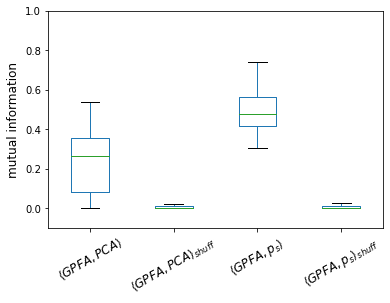

In [151]:
fig, ax = plt.subplots()
corr_df.boxplot(ax=ax, grid=False, rot=45, showfliers=False)
ax.set_xticklabels(corr_df.keys(), rotation=60)
ax.set_ylabel('mutual information', fontsize=12)

# for grant figure we want just pca and 
ax.set_ylim([-0.1, 1])
ax.set_xticklabels([r"$\left<GPFA, PCA\right>$", 
                    r"$\left<GPFA, PCA\right>_{shuff}$", 
                    r"$\left<GPFA, p_{s}\right>$", 
                    r"$\left<GPFA, p_{s}\right>_{shuff}$", ], fontsize=12, rotation=30)

In [160]:
fig_path = os.path.join(exp_struct['folders']['processed'], 'fig_mutual_info.eps')
fig.savefig(fig_path, bbox_inches='tight')
logger.info('saved figure to ' + fig_path)

2022-06-05 21:53:45,757 root         INFO     saved figure to /mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/0644_g0/fig_mutual_info.eps


In [152]:
pairs = [['spk_gpf_0-sxx_pc_0', 'spk_gpf_0-sxx_pc_0_shuffle']]
pairs.append(['spk_gpf_0-pre_filt', 'spk_gpf_0-pre_filt_shuffle'])
pairs.append(['spk_gpf_0-pre_filt', 'spk_gpf_0-sxx_pc_0'])

for p in pairs:
    p.append(stats.mannwhitneyu(corr_df[p[0]], corr_df[p[1]]).pvalue)
    
pairs

[['spk_gpf_0-sxx_pc_0', 'spk_gpf_0-sxx_pc_0_shuffle', 5.137021413328932e-30],
 ['spk_gpf_0-pre_filt', 'spk_gpf_0-pre_filt_shuffle', 1.7022095974602283e-31],
 ['spk_gpf_0-pre_filt', 'spk_gpf_0-sxx_pc_0', 1.642470958469077e-21]]

In [177]:
corr_dict = {}

for corr_pair in corr_pairs:
    k = corr_pair[0] + '-' + corr_pair[1]
    
    corr_dict[k] =  bout_df.apply(lambda x: bout_correlations(x, corr_pair, 
                                                              corr_function=pearsonr), 
                                  axis=1)
    
corr_df = pd.DataFrame.from_dict(corr_dict)

(-0.5, 1.0)

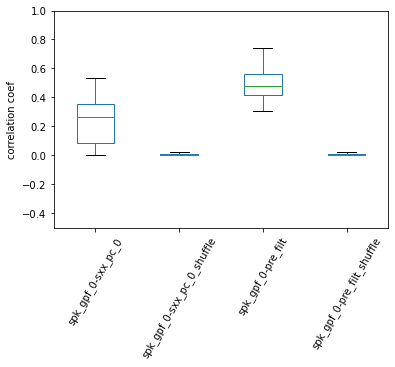

In [146]:
fig, ax = plt.subplots()
corr_df.boxplot(ax=ax, grid=False, rot=45, showfliers=False)
ax.set_xticklabels(corr_df.keys(), rotation=60)
ax.set_ylabel('correlation coef')

# for grant figure we want just pca and 
ax.set_ylim([-0.5, 1])
#ax.set_xticklabels(['<pca, gpa>', '<p_sub, gpfa>'], rotation=60)

In [131]:
corr_df.keys()

Index(['spk_gpf_0-sxx_pc_0', 'spk_gpf_0-pre_filt', 'spk_gpf_1-sxx_pc_0',
       'spk_gpf_1-pre_filt', 'spk_gpf_0-spk_gpf_1'],
      dtype='object')

In [126]:
corr_df

,spk_gpf_0-sxx_pc_0,spk_gpf_0-sxx_pc_0_shuffle,spk_gpf_0-pre_filt,spk_gpf_0-pre_filt_shuffle
0,0.370228,0.000000,0.410192,0.002780
1,0.053414,0.010587,0.408290,0.004344
2,0.040523,0.022836,0.418262,0.000000
3,0.344092,0.000000,0.423345,0.000000
4,0.033794,0.000000,0.484015,0.000000
...,...,...,...,...
85,0.513786,0.019564,0.641059,0.055433
86,0.328392,0.006740,0.572759,0.044154
87,0.256135,0.000000,0.565441,0.089586
88,0.350610,0.003463,0.666332,0.009190


In [128]:
from scipy import stats

In [143]:
pairs = [['spk_gpf_0-sxx_pc_0', 'spk_gpf_0-sxx_pc_0_shuffle']]
pairs.append(['spk_gpf_0-pre_filt', 'spk_gpf_0-pre_filt_shuffle'])
pairs.append(['spk_gpf_0-pre_filt', 'spk_gpf_0-sxx_pc_0'])

for p in pairs:
    p.append(stats.mannwhitneyu(corr_df[p[0]], corr_df[p[1]]).pvalue)

In [144]:
pairs

[['spk_gpf_0-sxx_pc_0', 'spk_gpf_0-sxx_pc_0_shuffle', 5.137021413328932e-30],
 ['spk_gpf_0-pre_filt', 'spk_gpf_0-pre_filt_shuffle', 1.7022095974602283e-31],
 ['spk_gpf_0-pre_filt', 'spk_gpf_0-sxx_pc_0', 1.642470958469077e-21]]

In [136]:
corr_df[pairs[0][0]]

0     0.370228
1     0.053414
2     0.040523
3     0.344092
4     0.033794
        ...   
85    0.513786
86    0.328392
87    0.256135
88    0.350610
89    0.311817
Name: spk_gpf_0-sxx_pc_0, Length: 90, dtype: float64

In [141]:
stats.mannwhitneyu(corr_df[p[0]], corr_df[p[1]]).pvalue

1.7022095974602283e-31